In [567]:
import pandas as pd
from dtaidistance import dtw_ndim
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
# https://heartbeat.comet.ml/how-to-evaluate-clustering-based-models-in-python-503343816db2
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, ShuffleSplit, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.impute import KNNImputer

In [ ]:
df = pd.read_csv('vitals_trajectory_imputed_no_unimputable.csv')

In [ ]:
df

# DTW

In [ ]:
# record row index and event hour of died patient, which should be removed from traj_arr
death_info=df[df['event_hour']>df['died_hour_round']][['EncID','event_hour']]
death_encid_index = [df['EncID'].unique().tolist().index(i) for i in death_info['EncID'].tolist()]
death_info['encid_index'] = death_encid_index
to_remove = death_info.sort_values(['encid_index','event_hour']).groupby('encid_index').first()

In [ ]:
to_remove

In [ ]:
# [[feature1_time1, feature2_time1, feature3_time1], [feature1_time2, feature2_time2, feature3_time2], ...]
traj_arr = np.reshape(np.array(df[["MAPImputed","PULSEImputed","RESP_RATEImputed",
                                   "SBPImputed","SF_RATIOImputed","TEMPImputed"]]), 
                      (df['EncID'].nunique(),df['event_hour'].nunique(),6))
traj_arr.shape

In [ ]:
traj_list = traj_arr.copy().tolist()
for idx,hr in zip(to_remove.index.tolist(),to_remove['event_hour'].tolist()):
    traj_i_updated = np.delete(traj_list[idx],np.s_[hr:13], axis = 0)
    traj_list[idx] = traj_i_updated.tolist()
    print(to_remove.loc[idx]['EncID'],len(traj_list[idx]))

In [ ]:
# before removing na
dtw_ndim.distance(traj_arr[0], traj_arr[52], penalty = 5)

In [ ]:
# after removing na
dtw_ndim.distance(np.array(traj_list[0]), np.array(traj_list[52]), penalty = 5)

In [ ]:
# mt = dtw_ndim.distance_matrix(traj_arr, penalty = 1)
mt = np.zeros((traj_arr.shape[0],traj_arr.shape[0]))
start_time = time.time()
# function for dtw matrix
for i in range(traj_arr.shape[0]):
    j = i + 1
    #with open ('dtw_prog.txt', 'a') as f:
        #f.write(str(i))
        #f.write('\n')
    #f.close()
    print(round(time.time()-start_time,2), 'init: ', i,j)
    while j < traj_arr.shape[0]:
        dtw = dtw_ndim.distance(np.array(traj_list[i]), np.array(traj_list[j]), penalty = 5)
        mt[i,j] = dtw
        mt[j,i] = dtw
        j+= 1
        #print('loop', i,j)

In [ ]:
#pd.DataFrame(mt).to_csv('dtw_out.csv',index=False)
pyreadr.write_rds("dtw_out.Rds", pd.DataFrame(mt))

# Clusteirng

## Hierarchical

In [488]:
mt_v2 = pd.read_csv('dtw_out_v2.csv')
mt_pen2 = pd.read_csv('dtw_out_pen2.csv')

In [ ]:
# check dtw output
sns.heatmap(mt)

In [ ]:
# scipy hac
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
clusters = shc.linkage(mt, 
            method='ward', 
            metric="euclidean")
#pd.DataFrame(clusters).to_csv('hac_clusters.csv',index=False)

/tmp/ipykernel_18317/2017418800.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters_v2 = shc.linkage(mt_v2,


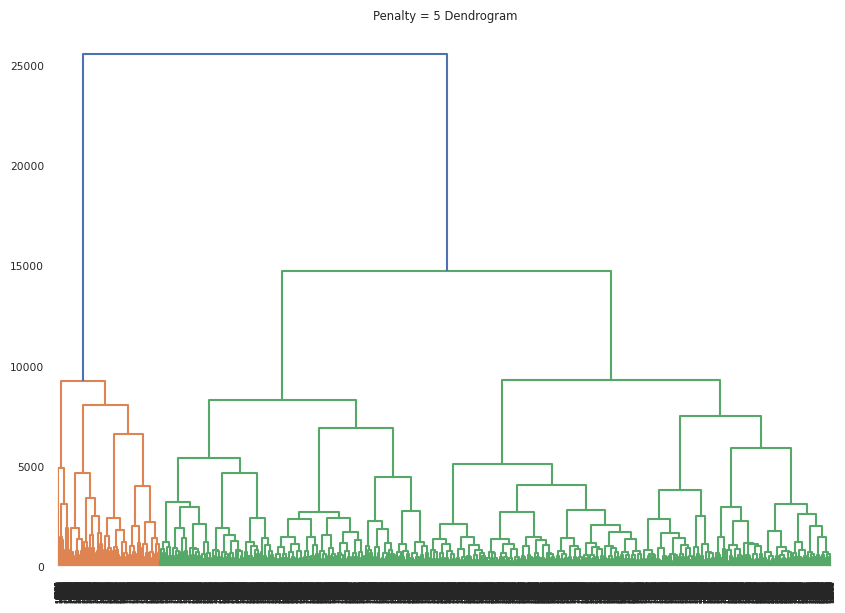

In [489]:
# scipy hac
plt.figure(figsize=(10, 7))
plt.title("Penalty = 5 Dendrogram")
clusters_v2 = shc.linkage(mt_v2, 
            method='ward', 
            metric="euclidean")
#pd.DataFrame(clusters).to_csv('hac_clusters.csv',index=False)

shc.dendrogram(Z=clusters_v2)
plt.show()

/tmp/ipykernel_18317/155329444.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters_pen2 = shc.linkage(mt_pen2,


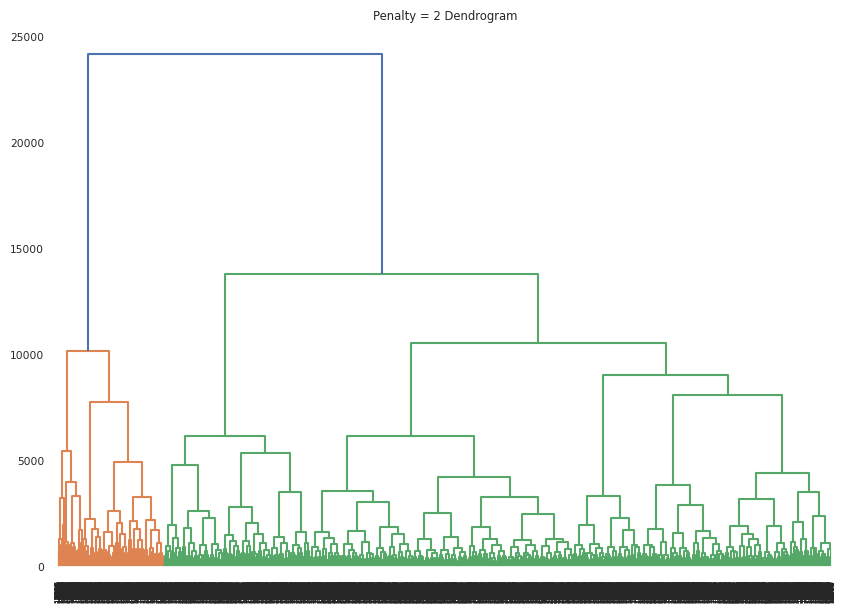

In [490]:
# scipy hac
plt.figure(figsize=(10, 7))
plt.title("Penalty = 2 Dendrogram")
clusters_pen2 = shc.linkage(mt_pen2, 
            method='ward', 
            metric="euclidean")
#pd.DataFrame(clusters).to_csv('hac_clusters.csv',index=False)

shc.dendrogram(Z=clusters_pen2)
plt.show()

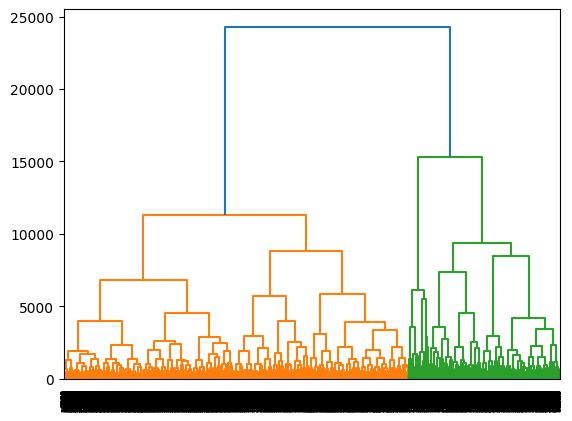

In [134]:
shc.dendrogram(Z=clusters)
plt.show()

In [491]:
# sklearn hac
hac = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
hac_3 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
hac_2 = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
hac_5 = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
hac_6 = AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage = 'ward')

In [136]:
# sklearn hac
y_hc = hac.fit_predict(mt)
y_hc3 = hac_3.fit_predict(mt)
y_hc2 = hac_2.fit_predict(mt)
y_hc5 = hac_5.fit_predict(mt)
y_hc6 = hac_6.fit_predict(mt)

/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [492]:
# sklearn hac
y_hc_v2 = hac.fit_predict(mt_v2)
y_hc3_v2 = hac_3.fit_predict(mt_v2)
y_hc2_v2 = hac_2.fit_predict(mt_v2)
y_hc5_v2 = hac_5.fit_predict(mt_v2)
y_hc6_v2 = hac_6.fit_predict(mt_v2)

/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return link

In [493]:
# sklearn hac
y_hc_pen2 = hac.fit_predict(mt_pen2)
y_hc3_pen2 = hac_3.fit_predict(mt_pen2)
y_hc2_pen2 = hac_2.fit_predict(mt_pen2)
y_hc5_pen2 = hac_5.fit_predict(mt_pen2)
y_hc6_pen2 = hac_6.fit_predict(mt_pen2)

/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return link

In [150]:
# sklearn metrics
print('silhouette for clusters size of 2, 3 and 4:', silhouette_score(mt,y_hc2), silhouette_score(mt,y_hc3), silhouette_score(mt,y_hc))
print('davis bouldin for clusters size of 2, 3 and 4:', davies_bouldin_score(mt,y_hc2), davies_bouldin_score(mt,y_hc3), davies_bouldin_score(mt,y_hc))
print('calinski harabasz for clusters size of 2, 3 and 4:', calinski_harabasz_score(mt,y_hc2), calinski_harabasz_score(mt,y_hc3), calinski_harabasz_score(mt,y_hc))

silhouette for clusters size of 2, 3 and 4: 0.28273293600873467 0.24161392029011206 0.11211336938942845
davis bouldin for clusters size of 2, 3 and 4: 1.5522064482889986 1.562729757714342 1.8906102610031157
calinski harabasz for clusters size of 2, 3 and 4: 4578.404207747468 3727.678890251248 3157.639043711719


In [153]:
# sklearn metrics
print('silhouette for clusters size of 5, 6:', silhouette_score(mt,y_hc5), silhouette_score(mt,y_hc6))
print('davis bouldin for clusters size of 5, 6:', davies_bouldin_score(mt,y_hc5), davies_bouldin_score(mt,y_hc6))
print('calinski harabasz for clusters size of 5, 6:', calinski_harabasz_score(mt,y_hc5), calinski_harabasz_score(mt,y_hc6))

silhouette for clusters size of 5, 6: 0.11121513541098796 0.10999300408499406
davis bouldin for clusters size of 5, 6: 2.026533638434292 1.973934024868756
calinski harabasz for clusters size of 5, 6: 2775.9679607526946 2553.3043808709253


best silhouette is 0.28 = 2 clusters
best davis bouldin is 1.55 = 2 clusters
best calinski harabasz is 4578 = 2 clusters

In [508]:
# sklearn metrics pen=5 data=v2
print('silhouette ', silhouette_score(mt_v2,y_hc2_v2), silhouette_score(mt_v2,y_hc3_v2), silhouette_score(mt_v2,y_hc_v2), silhouette_score(mt_v2,y_hc5_v2), silhouette_score(mt_v2,y_hc6_v2 ))
print('davis bouldin', davies_bouldin_score(mt_v2,y_hc2_v2), davies_bouldin_score(mt_v2,y_hc3_v2), davies_bouldin_score(mt_v2,y_hc_v2), davies_bouldin_score(mt_v2,y_hc5_v2), davies_bouldin_score(mt_v2,y_hc6_v2))
print('calinski harabasz:', calinski_harabasz_score(mt_v2,y_hc2_v2), calinski_harabasz_score(mt_v2,y_hc3_v2), calinski_harabasz_score(mt_v2,y_hc_v2), calinski_harabasz_score(mt_v2,y_hc5_v2), calinski_harabasz_score(mt_v2,y_hc6_v2))

silhouette  0.41884062849311315 0.1646341942161603 0.10585639527285257 0.1044244157633102 0.09523408560201241
davis bouldin 1.173588309651756 1.8243895903542662 1.9630283319183506 1.862489314202455 1.9850475522102968
calinski harabasz: 5237.892038990411 4039.608119501988 3159.8495484430064 2764.8545278709294 2504.2179676048045


In [509]:
# sklearn metrics pen=2 data=v2
print('silhouette ', silhouette_score(mt_pen2,y_hc2_pen2), silhouette_score(mt_pen2,y_hc3_pen2), silhouette_score(mt_pen2,y_hc_pen2), silhouette_score(mt_pen2,y_hc5_pen2), silhouette_score(mt_pen2,y_hc6_pen2 ))
print('davis bouldin', davies_bouldin_score(mt_pen2,y_hc2_pen2), davies_bouldin_score(mt_pen2,y_hc3_pen2), davies_bouldin_score(mt_pen2,y_hc_pen2), davies_bouldin_score(mt_pen2,y_hc5_pen2), davies_bouldin_score(mt_pen2,y_hc6_pen2))
print('calinski harabasz:', calinski_harabasz_score(mt_pen2,y_hc2_pen2), calinski_harabasz_score(mt_pen2,y_hc3_pen2), calinski_harabasz_score(mt_pen2,y_hc_pen2), calinski_harabasz_score(mt_pen2,y_hc5_pen2), calinski_harabasz_score(mt_pen2,y_hc6_pen2))

silhouette  0.3911803907704186 0.1771411846739278 0.11080550518614239 0.11490162581020717 0.10646224629517355
davis bouldin 1.2432128741734754 1.7886045212163024 2.1115416900037687 2.026111613234998 1.8635331583844497
calinski harabasz: 4700.584858410377 3541.2302917563243 2933.129161986965 2670.053731834647 2485.7458202282583


## Kmeans

In [163]:
# test kmeans plotting see: https://datascience.oneoffcoder.com/kmc-bic-aic.html
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn

def get_km(k, X):
    km = KMeans(n_clusters=k)
    km.fit(X)
    return km

def get_bic_aic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return gmm.bic(X), gmm.aic(X)

def get_score(k, X):
    km = get_km(k, X)
    y_pred = km.predict(X)
    bic, aic = get_bic_aic(k, X)
    return k, bic, aic

In [164]:
# bic kmeans
kmeans = pd.DataFrame([get_score(k, mt) for k in range(2, 6)],
                  columns=['k', 'BIC', 'AIC'])
kmeans

/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

,k,BIC,AIC
0,2,5.051386e+08,-7.218302e+08
1,3,1.050334e+09,-7.901194e+08
2,4,1.651521e+09,-8.024164e+08
3,5,2.343614e+09,-7.238079e+08


In [165]:
kmeans6 = pd.DataFrame([get_score(k, mt) for k in range(6, 7)],
                  columns=['k', 'BIC', 'AIC'])
kmeans6

/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,k,BIC,AIC
0,6,3.057807e+09,-6.230996e+08


## Hierarchical, TSNE visualizatinons 

In [516]:
# not specify number of clusters for dendrogram
model_v2 = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model_v2 = model_v2.fit(mt_v2)

model_pen2 = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model_pen2 = model_pen2.fit(mt_pen2)

/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [ ]:
# Create linkage matrix for hierarchical clustering
def plot_dendrogram(model, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

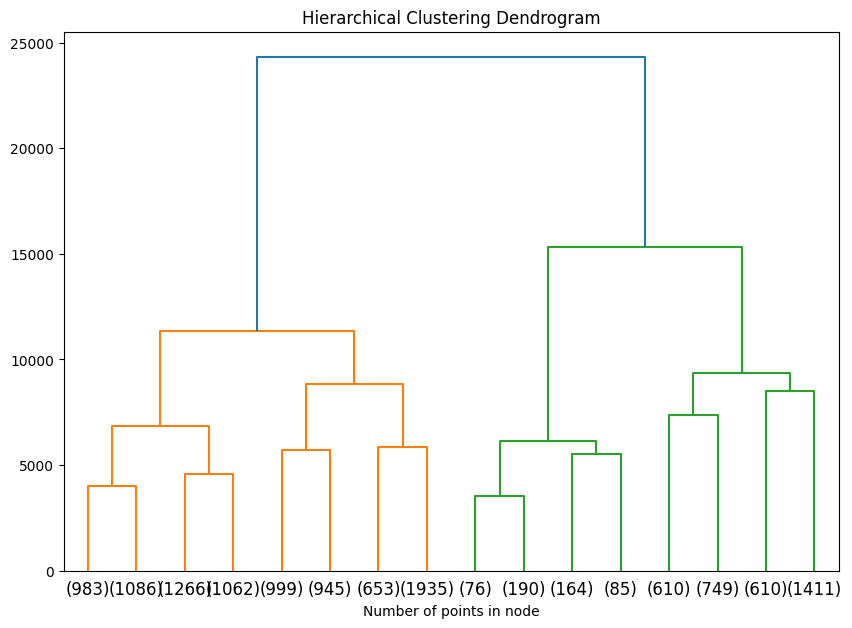

In [131]:
# plot the top three levels of the dendrogram - ORIGINAL DATA
plt.figure(figsize=(10,7))
plt.xlabel("Number of points in node")
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.show()

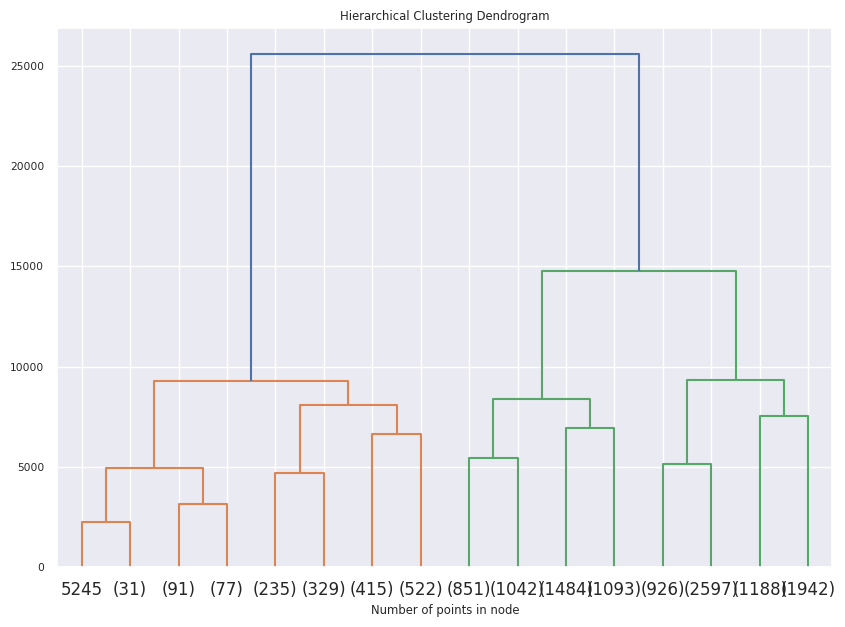

In [517]:
# plot the top three levels of the dendrogram - V2 DATA, PENALTY = 5
plt.figure(figsize=(10,7))
plt.xlabel("Number of points in node")
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model_v2, truncate_mode='level', p=3)
plt.show()

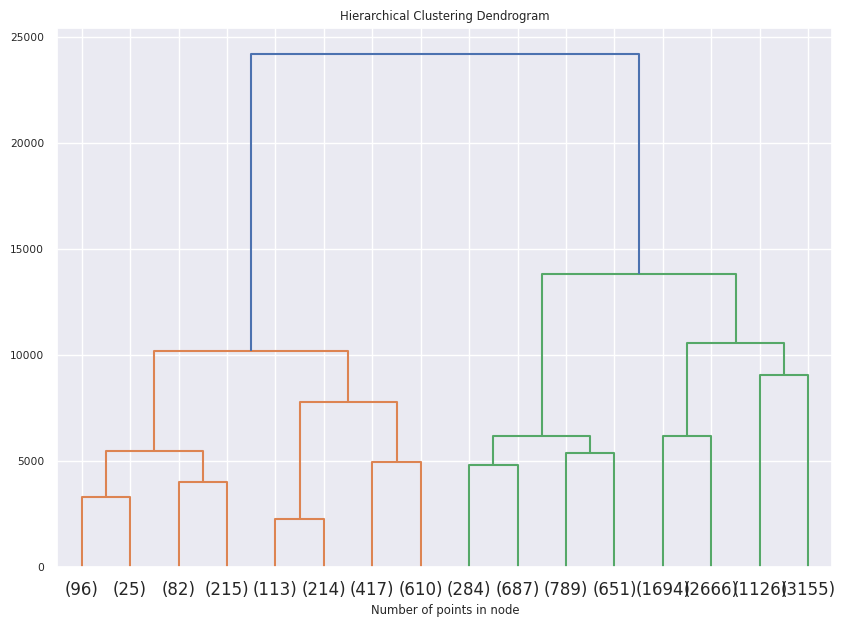

In [518]:
# plot the top three levels of the dendrogram - V2 DATA, PENALTY = 2
plt.figure(figsize=(10,7))
plt.xlabel("Number of points in node")
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model_pen2, truncate_mode='level', p=3)
plt.show()

In [519]:
'''
with open(r'hac_label_2cluster.txt', 'w') as fp:
    for item in y_hc2:
        fp.write("%s\n" % item)
    print('Done')
'''

'\nwith open(r\'hac_label_2cluster.txt\', \'w\') as fp:\n    for item in y_hc2:\n        fp.write("%s\n" % item)\n    print(\'Done\')\n'

In [520]:
'''
with open(r'hac_label_2cluster_v2.txt', 'w') as fp:
    for item in y_hc2_v2:
        fp.write("%s\n" % item)
    print('Done')
'''

Done


In [515]:
'''
with open(r'hac_label_2cluster_pen2.txt', 'w') as fp:
    for item in y_hc2_pen2:
        fp.write("%s\n" % item)
    print('Done')
'''

Done


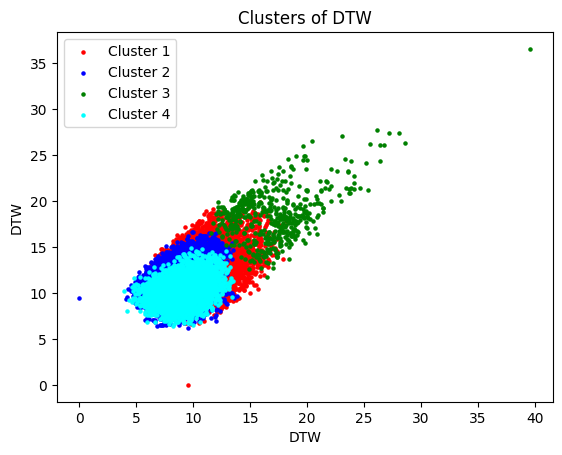

In [137]:
# visualize cluster on raw dtw matrix
plt.scatter(mt[y_hc == 0, 0], mt[y_hc == 0, 1], s = 5, c = 'red', label = 'Cluster 1') # plotting cluster 2
plt.scatter(mt[y_hc == 1, 0], mt[y_hc == 1, 1], s = 5, c = 'blue', label = 'Cluster 2') # plotting cluster 3
plt.scatter(mt[y_hc == 2, 0], mt[y_hc == 2, 1], s = 5, c = 'green', label = 'Cluster 3') # plotting cluster 4
plt.scatter(mt[y_hc == 3, 0], mt[y_hc == 3, 1], s = 5, c = 'cyan', label = 'Cluster 4')  # plotting cluster 5
# plot title addition
plt.title('Clusters of DTW')
# labelling the x-axis
plt.xlabel('DTW')
# label of the y-axis
plt.ylabel('DTW')
# printing the legend
plt.legend()
# show the plot
plt.show()

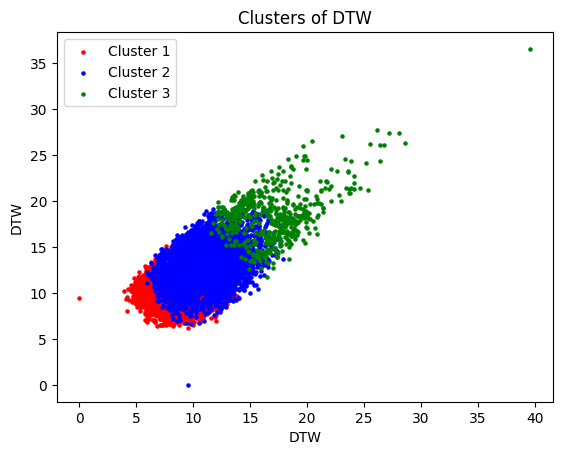

In [138]:
# visualize cluster on raw dtw matrix
plt.scatter(mt[y_hc3 == 0, 0], mt[y_hc3 == 0, 1], s = 5, c = 'red', label = 'Cluster 1') # plotting cluster 2
plt.scatter(mt[y_hc3 == 1, 0], mt[y_hc3 == 1, 1], s = 5, c = 'blue', label = 'Cluster 2') # plotting cluster 3
plt.scatter(mt[y_hc3 == 2, 0], mt[y_hc3 == 2, 1], s = 5, c = 'green', label = 'Cluster 3') # plotting cluster 4
# plot title addition
plt.title('Clusters of DTW')
# labelling the x-axis
plt.xlabel('DTW')
# label of the y-axis
plt.ylabel('DTW')
# printing the legend
plt.legend()
# show the plot
plt.show()

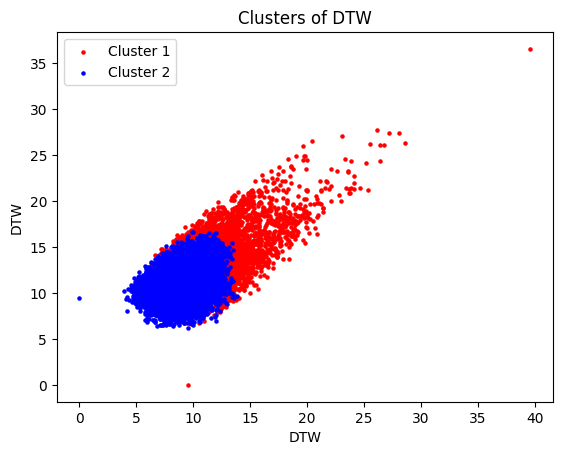

In [143]:
# visualize cluster on raw dtw matrix, RERUN
plt.scatter(mt[y_hc2 == 0, 0], mt[y_hc2 == 0, 1], s = 5, c = 'red', label = 'Cluster 1') # plotting cluster 2
plt.scatter(mt[y_hc2 == 1, 0], mt[y_hc2 == 1, 1], s = 5, c = 'blue', label = 'Cluster 2') # plotting cluster 3
# plot title addition
plt.title('Clusters of DTW')
# labelling the x-axis
plt.xlabel('DTW')
# label of the y-axis
plt.ylabel('DTW')
# printing the legend
plt.legend()
# show the plot
plt.show()

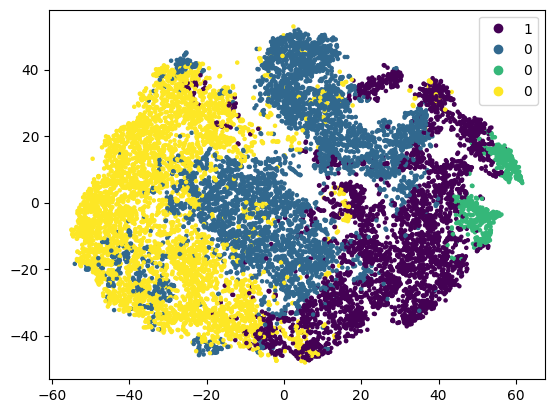

In [140]:
# tsne with cluster label
tsne = TSNE(perplexity = 100)
Xt = tsne.fit_transform(mt)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_hc, s= 5)
plt.legend(handles=plot.legend_elements()[0], labels=list(y_hc))
plt.show()

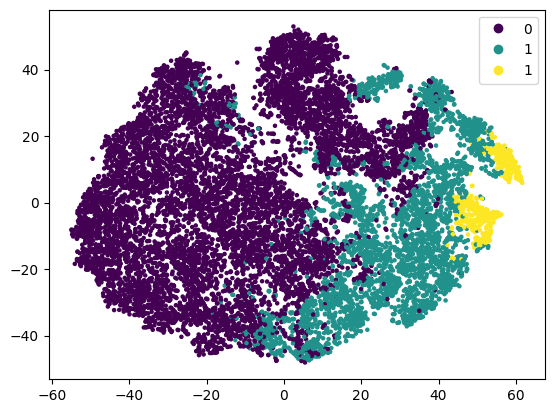

In [141]:
# tsne with cluster label
tsne = TSNE(perplexity = 100)
Xt = tsne.fit_transform(mt)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_hc3, s= 5)
plt.legend(handles=plot.legend_elements()[0], labels=list(y_hc3))
plt.show()

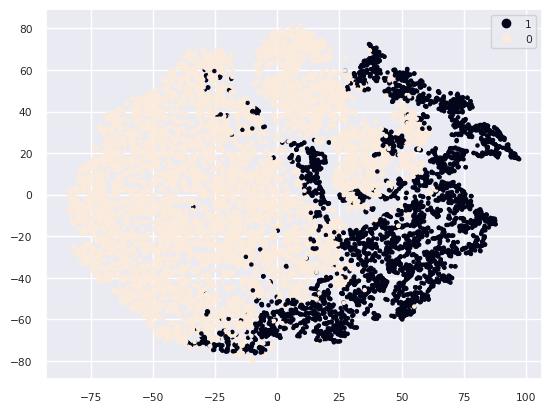

In [525]:
# tsne with cluster label
tsne = TSNE()
Xt = tsne.fit_transform(mt)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_hc2, s= 5)
plt.legend(handles=plot.legend_elements()[0], labels=list(y_hc2))
plt.show()

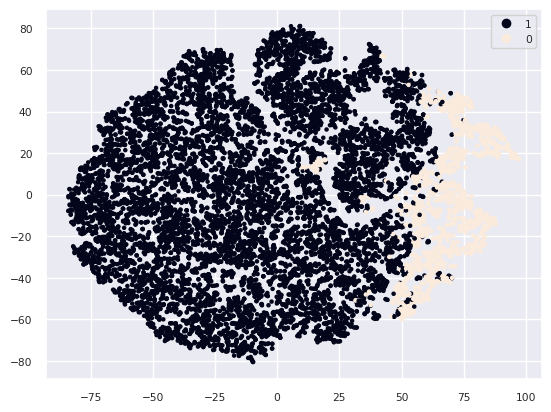

In [526]:
# tsne with cluster label - new label pen = 5
tsne = TSNE()
Xt = tsne.fit_transform(mt)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_hc2_v2, s= 5)
plt.legend(handles=plot.legend_elements()[0], labels=list(y_hc2))
plt.show()

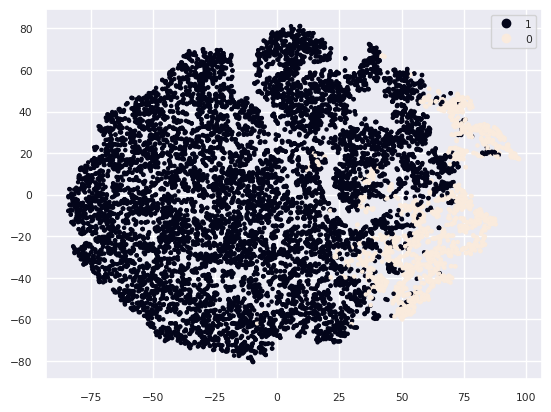

In [527]:
# tsne with cluster label - new label pen = 2
tsne = TSNE()
Xt = tsne.fit_transform(mt)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_hc2_pen2, s= 5)
plt.legend(handles=plot.legend_elements()[0], labels=list(y_hc2))
plt.show()

## Add cluster to metadata

In [535]:
# add label to dataframe
y_hc_rep = np.repeat(y_hc2,13)
print(len(y_hc_rep))
df['cluster_label_orig'] = y_hc_rep.tolist()
print(df.groupby(['EncID']).first()['cluster_label_orig'].value_counts())

166712
1    8929
0    3895
Name: cluster_label_orig, dtype: int64


In [536]:
# new data pen = 5
y_hcv2_rep = np.repeat(y_hc2_v2,13)
print(len(y_hcv2_rep))
df['cluster_label_v2'] = y_hcv2_rep.tolist()
print(df.groupby(['EncID']).first()['cluster_label_v2'].value_counts())

166712
0    11123
1     1701
Name: cluster_label_v2, dtype: int64


In [537]:
# new data pen = 2
y_hcpen2_rep = np.repeat(y_hc2_pen2,13)
print(len(y_hcpen2_rep))
df['cluster_label_pen2'] = y_hcpen2_rep.tolist()
print(df.groupby(['EncID']).first()['cluster_label_pen2'].value_counts())

166712
0    11052
1     1772
Name: cluster_label_pen2, dtype: int64


In [543]:
#df.to_csv('vitals_trajectory_cluster_label_2cluster.csv',index='False')
df.to_csv('vitals_trajectory_cluster_label_2cluster.csv',index='False')

# Labs/Interventions

## Data Processing

In [544]:
df = pd.read_csv('vitals_trajectory_cluster_label_2cluster.csv')

In [545]:
interv = pd.read_csv('vitals_trajectory_labs_interv.csv')
interv = interv[interv['EncID'].isin(df['EncID'].unique().tolist())]
meta_interv = interv[['EncID','gender','race_ethnicity','malignancy','transplant','tech_dep','admission_from','los_days']]

In [546]:
# meta data 
meta = pd.merge(df[['EncID','hospital_id','age_group','mods_day7','died_in_hosp','died_hour_round']].drop_duplicates(),meta_interv,on='EncID',how='right')
meta

,EncID,hospital_id,age_group,mods_day7,died_in_hosp,died_hour_round,gender,race_ethnicity,malignancy,transplant,tech_dep,admission_from,los_days
0,10_P13,P13,24 to 59 mo,0,0,NaN,Male,White,0,0,1,ED,10.992361
1,100_P13,P13,144 to 216 mo,1,0,NaN,Female,White,0,0,1,ED,13.765972
2,1000_P13,P13,144 to 216 mo,0,0,NaN,Female,White,0,1,1,Inpatient,14.731250
3,1000044335_P05,P05,24 to 59 mo,0,0,NaN,Male,White,0,0,0,ED,13.490278
4,100005_P12,P12,60 to 143 mo,0,0,NaN,Male,Other,0,0,1,Direct,27.253472
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12819,9977 L2_P01,P01,144 to 216 mo,0,0,NaN,Male,Hispanic,1,0,0,Inpatient,2.852778
12820,998_P10,P10,60 to 143 mo,0,0,NaN,Female,Hispanic,1,0,0,OR,6.805556
12821,998_P13,P13,24 to 59 mo,1,0,NaN,Female,White,0,1,0,Direct,44.877083
12822,999_P10,P10,144 to 216 mo,0,0,NaN,Female,Black,0,0,1,Inpatient,32.358333


In [547]:
# get daily measurements into separate df
daily = [i for i in interv.columns.tolist() if i not in meta.columns.tolist()]
daily.remove('mods_day1')
daily = ['EncID'] + daily
daily_df = interv[daily]
daily_df.index = daily_df['EncID']
daily_df = daily_df.drop('EncID',axis = 1)

In [548]:
# get list of meas/interv names
pd.set_option('display.max_rows', 20)
measures = []
for i in daily_df.columns.tolist():
    if len(i.split('_')) == 2:
        measures.append(i.split('_')[0])
    else:
        measures.append(i.split('_')[0] + '_'+ i.split('_')[1])
meas = list(set(measures))   

# get worst value over 3 days
meas_df = daily_df.copy()
for i in meas:
    if i == 'alc' or i == 'ph_min' or i =='plts':
        daily_cols = [j for j in daily_df.columns.tolist() if i in j]
        meas_df[i] = daily_df[daily_cols].min(axis = 1)
    else:
        daily_cols = [j for j in daily_df.columns.tolist() if i in j]
        meas_df[i] = daily_df[daily_cols].max(axis = 1)
meas_df = meas_df.drop(daily_df.columns.tolist(), axis = 1)

# change vis to categorical 0 or 1
meas_df['vaso_drug'] = [0 if i == 0 else 1 for i in meas_df['vis'].tolist()]
meas_df = meas_df.drop('vis', axis = 1)

In [549]:
# na count after 3day max/min
pd.DataFrame(meas_df.isna().sum()).sort_values(0, ascending=False)

,0
d_dimer,10695
bands,7589
ptt,6171
inr,6110
ast,5389
bili,5364
alt,5308
lact,4750
alc,2767
ph_min,2506


In [550]:
# merge with metadata
meta_meas = pd.merge(meta, meas_df, right_index=True, left_on = 'EncID')
meta_meas.index = meta_meas['EncID']
meta_meas = meta_meas.drop('EncID', axis = 1)

In [551]:
# reordber based on meaning
new_order = [ 'gender', 'race_ethnicity','age_group', 'hospital_id','admission_from','tech_dep', 
             'los_days', 'mods_day7', 'died_in_hosp','died_hour_round', 'malignancy','transplant', 
             'vent', 'crrt', 'ecmo','vaso_drug',
             'pco2','lact','ph_min','gluc_max',
             'inr','ptt','d_dimer','plts',
             'alt', 'ast','bili', 'creat', 'bun' ,
             'wbc_max','bands','alc']

full_names = ['ventilator','CRRT','ECMO','vasoactive drug',
'PCO2 (ventilation)', 'lactate (inflammation)','pH', 'glucose', 
'INR (coagulation)','PTT(coagulation)','D-dimer (clotting)','platelets (clotting)' ,
'ALT (liver)','AST (liver)','bilrubin (liver)','creatinine (kidney)' ,'BUN (kidney)',
'WBC (infection)','band (infection)','lymphocyte (infection)']

meta_meas = meta_meas[new_order]

In [552]:
# merge with cluster
cluster_lab = df[['EncID','cluster_label_orig','cluster_label_v2','cluster_label_pen2']].drop_duplicates()
meta_clust = pd.merge(meta_meas, cluster_lab, left_index=True, right_on='EncID')
meta_clust.index = meta_clust['EncID']
meta_clust = meta_clust.drop('EncID', axis = 1)
meta_clust

,gender,race_ethnicity,age_group,hospital_id,admission_from,tech_dep,los_days,mods_day7,died_in_hosp,died_hour_round,...,ast,bili,creat,bun,wbc_max,bands,alc,cluster_label_orig,cluster_label_v2,cluster_label_pen2
EncID,,,,,,,,,,,,,,,,,,,,,
10_P13,Male,White,24 to 59 mo,P13,ED,1,10.992361,0,0,NaN,...,1219.0,0.3,0.50,27.0,20.20,NaN,0.16000,1,0,0
100_P13,Female,White,144 to 216 mo,P13,ED,1,13.765972,1,0,NaN,...,42.0,0.2,0.40,6.0,4.79,NaN,0.68000,0,0,0
1000_P13,Female,White,144 to 216 mo,P13,Inpatient,1,14.731250,0,0,NaN,...,968.0,10.7,0.50,16.0,15.08,NaN,0.83000,1,0,0
1000044335_P05,Male,White,24 to 59 mo,P05,ED,0,13.490278,0,0,NaN,...,59.0,0.4,0.54,22.0,7.60,26.0,1.09200,1,0,0
100005_P12,Male,Other,60 to 143 mo,P12,Direct,1,27.253472,0,0,NaN,...,39.0,0.4,0.80,30.0,22.10,7.0,0.50500,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977 L2_P01,Male,Hispanic,144 to 216 mo,P01,Inpatient,0,2.852778,0,0,NaN,...,99.0,1.4,0.68,27.0,3.12,NaN,0.24600,0,0,0
998_P10,Female,Hispanic,60 to 143 mo,P10,OR,0,6.805556,0,0,NaN,...,NaN,0.6,0.30,9.0,15.40,NaN,0.00008,1,0,0
998_P13,Female,White,24 to 59 mo,P13,Direct,0,44.877083,1,0,NaN,...,116.0,24.5,0.20,4.0,8.06,NaN,1.09000,1,0,0


In [553]:
# convert categorical data to category data type
for i in ['tech_dep', 'mods_day7', 'died_in_hosp', 'malignancy', 'transplant', 'vent', 'crrt', 'ecmo','vaso_drug','cluster_label_orig','cluster_label_v2', 'cluster_label_pen2']:
    meta_clust[i] = meta_clust[i].astype("category")

## EDA

array([[<AxesSubplot: title={'center': 'los_days'}>,
        <AxesSubplot: title={'center': 'died_hour_round'}>,
        <AxesSubplot: title={'center': 'pco2'}>,
        <AxesSubplot: title={'center': 'lact'}>,
        <AxesSubplot: title={'center': 'ph_min'}>],
       [<AxesSubplot: title={'center': 'gluc_max'}>,
        <AxesSubplot: title={'center': 'inr'}>,
        <AxesSubplot: title={'center': 'ptt'}>,
        <AxesSubplot: title={'center': 'd_dimer'}>,
        <AxesSubplot: title={'center': 'plts'}>],
       [<AxesSubplot: title={'center': 'alt'}>,
        <AxesSubplot: title={'center': 'ast'}>,
        <AxesSubplot: title={'center': 'bili'}>,
        <AxesSubplot: title={'center': 'creat'}>,
        <AxesSubplot: title={'center': 'bun'}>],
       [<AxesSubplot: title={'center': 'wbc_max'}>,
        <AxesSubplot: title={'center': 'bands'}>,
        <AxesSubplot: title={'center': 'alc'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

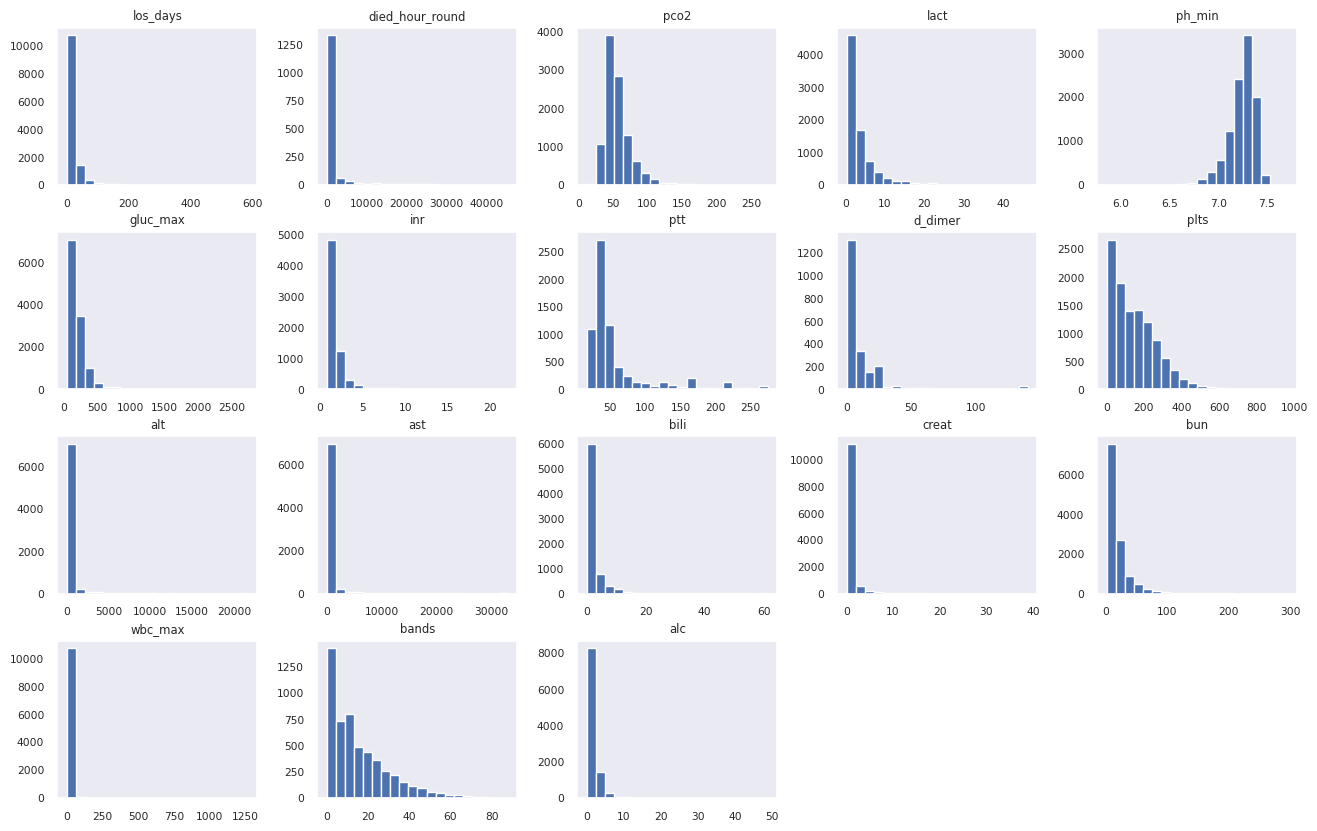

In [554]:
meta_clust.hist(figsize=(16,10), grid=False, layout=(4, 5), bins = 20)

<AxesSubplot: xlabel='vaso_drug', ylabel='count'>

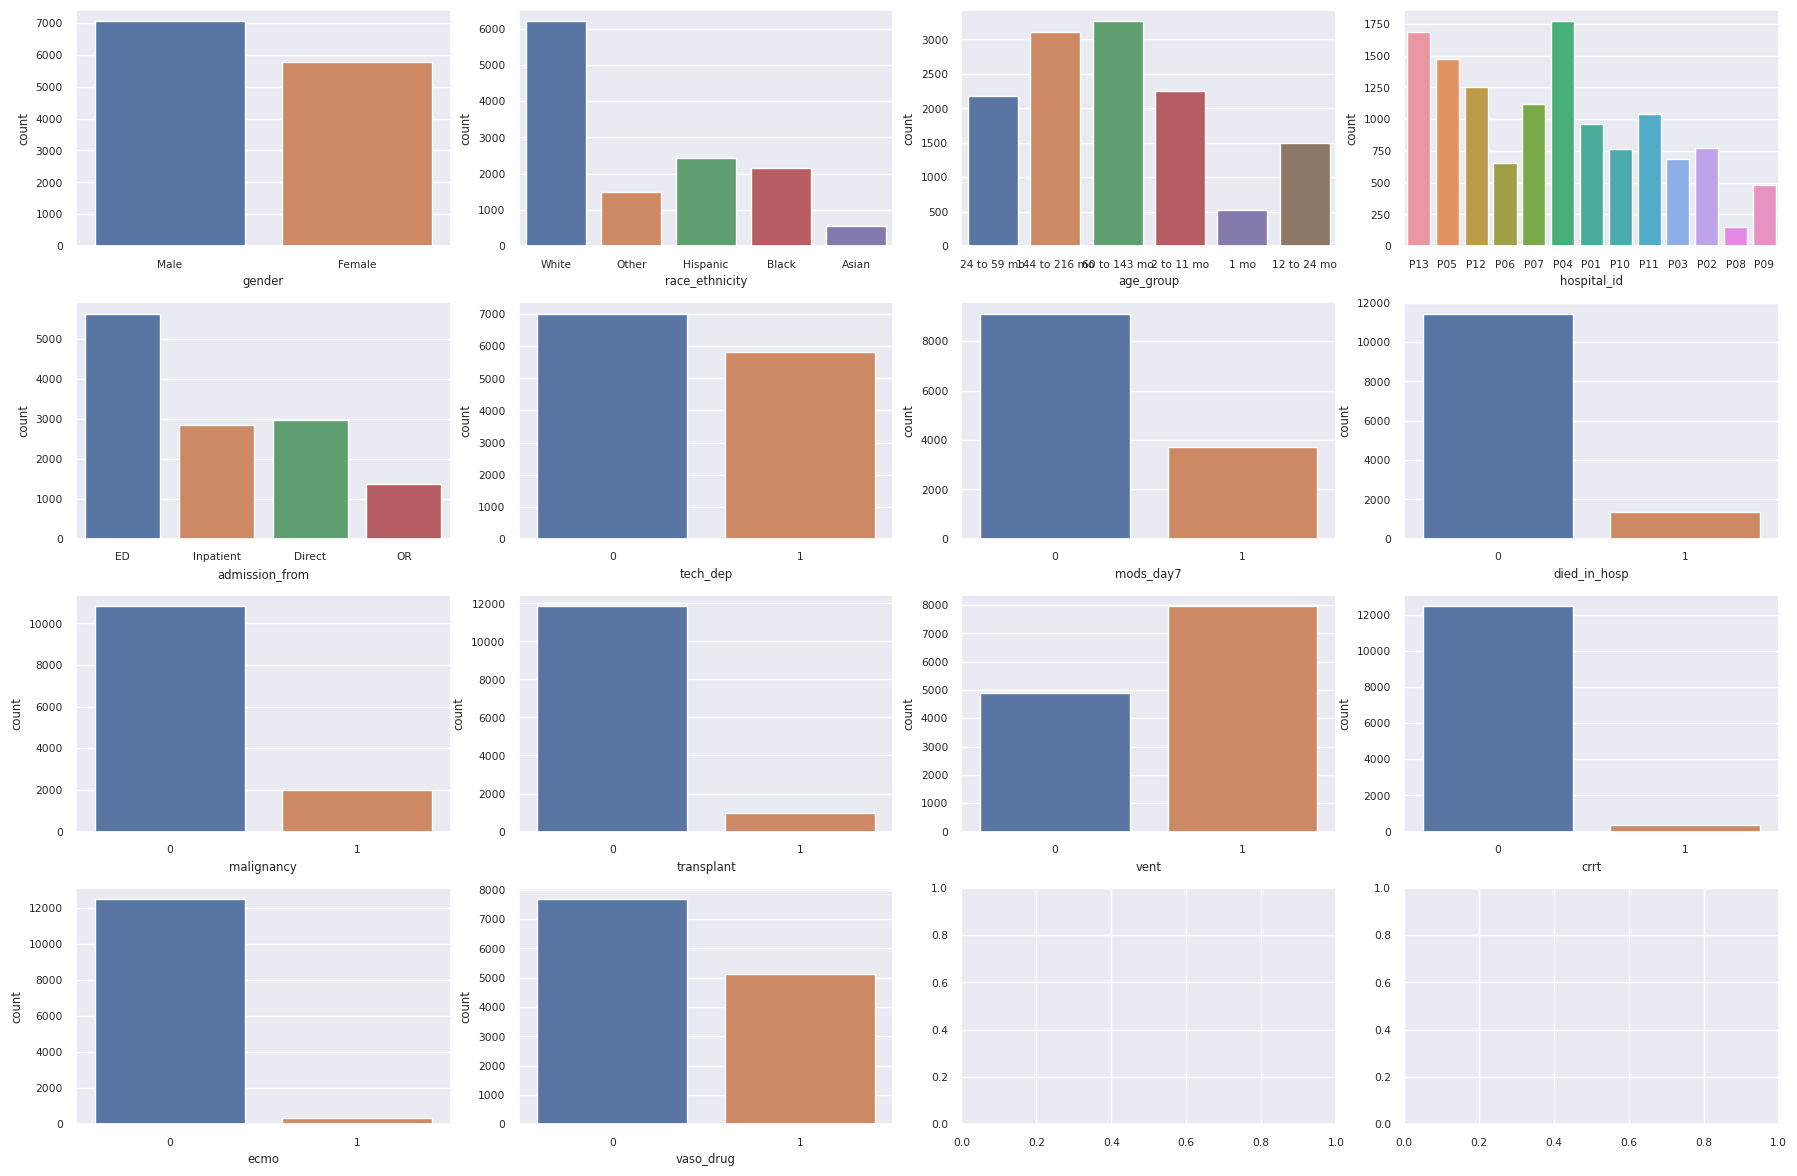

In [555]:
cat = ['gender', 'race_ethnicity','age_group', 'hospital_id','admission_from','tech_dep','mods_day7','died_in_hosp','malignancy','transplant','vent', 'crrt', 'ecmo','vaso_drug']

fig, axes = plt.subplots(4, 4, figsize=(18, 12))
fig.tight_layout(pad=2.5)

sns.countplot(ax=axes[0, 0], data=meta_clust, x=cat[0])
sns.countplot(ax=axes[0, 1], data=meta_clust, x=cat[1])
sns.countplot(ax=axes[0, 2], data=meta_clust, x=cat[2])
sns.countplot(ax=axes[0, 3], data=meta_clust, x=cat[3])
sns.countplot(ax=axes[1, 0], data=meta_clust, x=cat[4])
sns.countplot(ax=axes[1, 1], data=meta_clust, x=cat[5])
sns.countplot(ax=axes[1, 2], data=meta_clust, x=cat[6])
sns.countplot(ax=axes[1, 3], data=meta_clust, x=cat[7])
sns.countplot(ax=axes[2, 0], data=meta_clust, x=cat[8])
sns.countplot(ax=axes[2, 1], data=meta_clust, x=cat[9])
sns.countplot(ax=axes[2, 2], data=meta_clust, x=cat[10])
sns.countplot(ax=axes[2, 3], data=meta_clust, x=cat[11])
sns.countplot(ax=axes[3, 0], data=meta_clust, x=cat[12])
sns.countplot(ax=axes[3, 1], data=meta_clust, x=cat[13])

In [556]:
# convert categorical data to numerical values
gender_dict = {'Male':0, 'Female':1}
race_dict = {'White':0,'Hispanic':1, 'Black':2,'Asian':3,'Other':4}
age_dict = {'1 mo':0, '2 to 11 mo':1, '12 to 24 mo': 2, '24 to 59 mo': 3, '60 to 143 mo': 4, '144 to 216 mo':5}
hosp_dict = {'P01':1, 'P02':2, 'P03': 3, 'P04': 4, 'P05': 5, 'P06':6, 'P07':7, 'P08':8, 'P09': 9, 'P10': 10, 'P11': 11, 'P12': 12,'P13':13}
adm_dict = {'ED': 0, 'Inpatient':1, 'Direct': 2, 'OR':3}
meta_clust['gender_cat'] = [gender_dict[i] for i in meta_clust['gender'].tolist()]
meta_clust['race_cat'] = [race_dict[i] for i in meta_clust['race_ethnicity'].tolist()]
meta_clust['age_cat'] = [age_dict[i] for i in meta_clust['age_group'].tolist()]
meta_clust['hosp_cat'] = [hosp_dict[i] for i in meta_clust['hospital_id'].tolist()]
meta_clust['admission_cat'] = [adm_dict[i] for i in meta_clust['admission_from'].tolist()]

# convert categorical data to category data type
for i in ['gender_cat', 'race_cat', 'age_cat', 'hosp_cat', 'admission_cat']:
    meta_clust[i] = meta_clust[i].astype("category")

<AxesSubplot: >

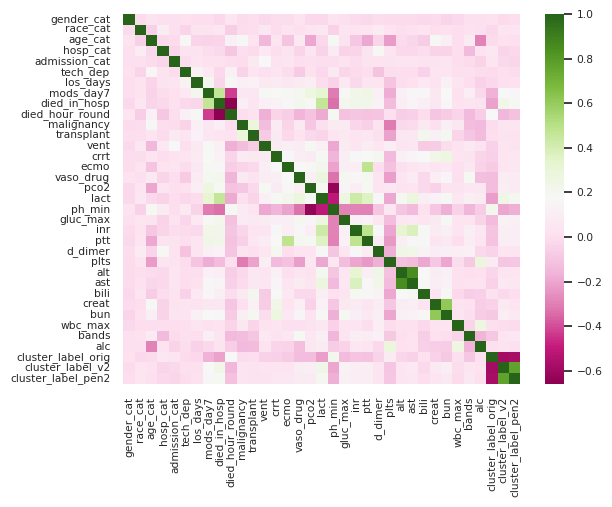

In [557]:
# bivariate correlation analysis
meta_cat = meta_clust.drop(['gender','race_ethnicity','age_group','hospital_id','admission_from'], axis=1)
meta_num = meta_cat.apply(pd.to_numeric)
new_order = [ 'gender_cat', 'race_cat','age_cat', 'hosp_cat','admission_cat','tech_dep', 
             'los_days', 'mods_day7', 'died_in_hosp','died_hour_round', 'malignancy','transplant', 
             'vent', 'crrt', 'ecmo','vaso_drug',
             'pco2','lact','ph_min','gluc_max',
             'inr','ptt','d_dimer','plts',
             'alt', 'ast','bili', 'creat', 'bun' ,
             'wbc_max','bands','alc','cluster_label_orig','cluster_label_v2','cluster_label_pen2']
meta_num= meta_num[new_order]

sns.set(font_scale=0.7)
sns.heatmap(meta_num.corr(), xticklabels=True, yticklabels=True, cmap="PiYG")

In [563]:
#meta_clust.to_csv('vitals_labs_cluster.csv')